In [1]:
#%pip install bertopic 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import bertopic
from bertopic import BERTopic


/opt/anaconda3/envs/compss211/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Cleaning

In [ ]:
df = pd.read_csv('../data/SPOTIFY_REVIEWS_tokens.csv')

In [19]:
import datetime as dt
df['review_timestamp'] = pd.to_datetime(df['review_timestamp'])
df2 = df[(df['review_timestamp'] >= '2019-11-15') & (df['review_timestamp'] <= '2023-11-15')]
print("Original:", len(df))
print("After the most recent 5 year:", len(df2))

Original: 3308617
After the most recent 5 year: 1669701


In [20]:
df_final = df2[~df2['length_type'].isin(['Short', 'Very short'])].reset_index(drop=True)
print(df2['length_type'].value_counts())
print(df_final['length_type'].value_counts())


length_type
Very short    614051
Long          587948
Short         269962
Medium        197652
Name: count, dtype: int64
length_type
Long      587948
Medium    197652
Name: count, dtype: int64


In [21]:
df_final = df_final[~df_final['review_text'].isin(['[deleted]', '[removed]'])].reset_index(drop=True)
df_final.shape
df_final.head()

,Unnamed: 0,review_id,pseudo_author_id,author_name,review_text,review_rating,review_likes,author_app_version,review_timestamp,raw_word_count,length_type,length_type2,tokens
0,1663991,979989f1-78a2-4576-a783-c763ae7a9ffa,157768270865747512306,A Google user,I love the fact that I can listen to nearly an...,4,1,8.5.31.676,2019-11-15 00:02:50,68.0,Long,Long,"['i', 'love', 'the', 'fact', 'that', 'i', 'can..."
1,1663997,bd98f73f-1bb1-42f8-ad7a-d12f4c3662e9,280812221700598190021,A Google user,Randomly stops playing.... I will be listening...,2,2,8.5.31.676,2019-11-15 00:18:54,64.0,Long,Long,"['randomly', 'stops', 'playing', '.', '.', '.'..."
2,1663998,7167a53f-b1c0-4eae-9f33-26295c73de76,765391996510868237903,A Google user,So far this has been a better experience than ...,5,0,8.5.31.676,2019-11-15 00:19:11,22.0,Long,Long,"['so', 'far', 'this', 'has', 'been', 'a', 'bet..."
3,1664000,9fb431b7-7f2b-494c-8f0d-2805dec40b70,307958352133874143584,A Google user,Great app for looking up and listening to ur f...,5,0,NaN,2019-11-15 00:20:11,11.0,Long,Long,"['great', 'app', 'for', 'looking', 'up', 'and'..."
4,1664001,e3872654-d562-422e-96c1-d2480db446f4,180538848993703574960,A Google user,I love this app so .uch cause zi get to listen...,5,0,8.5.29.828,2019-11-15 00:20:20,18.0,Long,Long,"['i', 'love', 'this', 'app', 'so', '.', 'uc', ..."


In [22]:
import re

def light_clean(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r"http\S+|www\.\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df_final['review_text_clean'] = df_final['review_text'].apply(light_clean)
docs = df_final['review_text_clean'].tolist()

In [ ]:
#%pip install scikit-learn
#%pip install PCA
from sklearn.decomposition import PCA
from bertopic import BERTopic



Note: you may need to restart the kernel to use updated packages.


In [15]:
custom_stopwords = {
    'spotify', 'app', 'music', 'song', 'songs', 'listen', 'player', 'play', 'playing',
     'use', 'using', 'experience',
    'really', 'like', 'love', 'good', 'bad', 'great', 'best', 'worst','ever'
    'get', 'got', 'want', 'even', 'work', 'working', 'issue', 'problem','much', 'one', 'also', 'every', 'please', 'still', 'time', 'times', 'would', 'could', 'still', 'new', 'old','ever'
}


In [25]:
from nltk.corpus import stopwords
import re

stop_words = set(stopwords.words('english'))
stop_words.update(custom_stopwords)


In [26]:
def remove_stopwords(text):
    # Convert to lowercase
    text = text.lower()
    # Extract word tokens
    tokens = re.findall(r'\b\w+\b', text)
    # Remove stopwords + very short tokens
    cleaned_tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    return " ".join(cleaned_tokens)


In [27]:
df_final['final_text'] = df_final['review_text_clean'].astype(str).apply(remove_stopwords)


# Using bag of words to compare token

In [ ]:
from collections import Counter

word_frequency_5 = Counter()

for text in df_final['final_text']:
    word_frequency_5.update(text.split())
top_fre_words_5 = word_frequency_5

countvalues = word_frequency_5.most_common(20)

countvalues 




[('premium', 121734),
 ('ads', 96472),
 ('playlist', 64786),
 ('update', 64703),
 ('get', 63167),
 ('free', 42976),
 ('listening', 41793),
 ('many', 38846),
 ('fix', 35691),
 ('phone', 35679),
 ('back', 33853),
 ('better', 32453),
 ('playlists', 30074),
 ('add', 29599),
 ('without', 29053),
 ('used', 28567),
 ('pay', 28552),
 ('make', 28405),
 ('download', 27856),
 ('find', 27403)]

In [16]:
df_good_playlist = df_final[
    (df_final['review_rating'] == 5) &
    (df_final['final_text'].str.contains(r'\bpremium\b', regex=True))
]




In [18]:
df_05 = df_final[df_final['review_rating'] == 5]['final_text'].fillna("")

from collections import Counter

word_frequency_5 = Counter()

for text in df_final[df_final['review_rating'] == 5]['final_text']:
    if isinstance(text, str):
        word_frequency_5.update(text.split())

countvalues = word_frequency_5.most_common(20)
countvalues


[('premium', 25157),
 ('easy', 18634),
 ('amazing', 17675),
 ('listening', 16863),
 ('get', 15911),
 ('ads', 14868),
 ('find', 13633),
 ('free', 13301),
 ('better', 12767),
 ('nice', 12759),
 ('playlist', 12727),
 ('awesome', 12084),
 ('favorite', 11374),
 ('playlists', 10677),
 ('years', 10364),
 ('enjoy', 9791),
 ('always', 9548),
 ('thank', 9489),
 ('quality', 9366),
 ('many', 9343)]

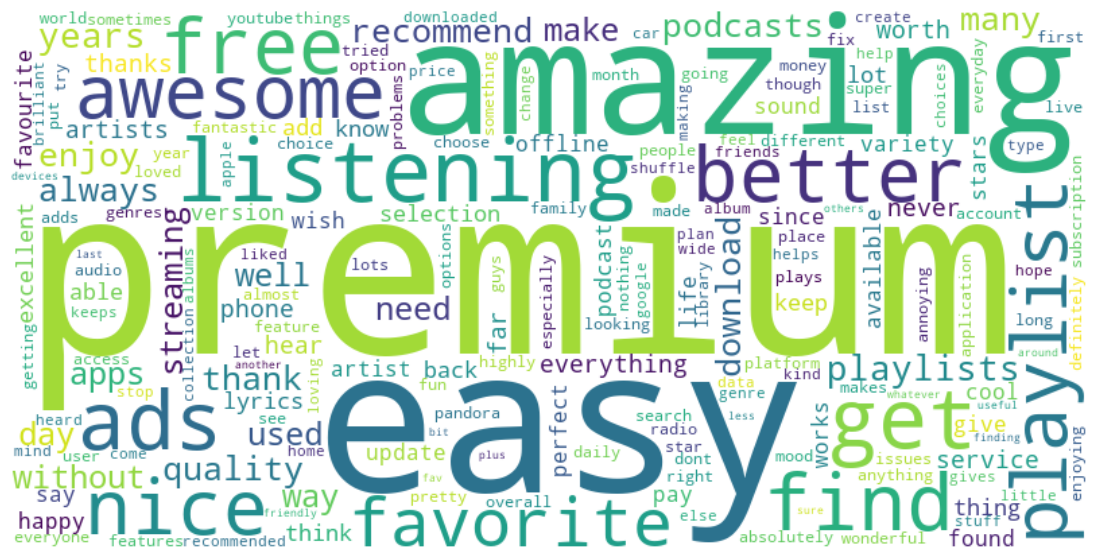

In [19]:
from wordcloud import WordCloud
wordcloud_5 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequency_5) 
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_5, interpolation='bilinear')
plt.axis('off')
plt.show()

In [31]:
df_0 = df_final[df_final['review_rating'] == 1]
word_frequency_0 = Counter()
for text in df_0['final_text']:
    word_frequency_0.update(text.split())
top_fre_words_0 = word_frequency_0

countvalues = word_frequency_0.most_common(20)
countvalues



[('premium', 59436),
 ('ads', 41765),
 ('update', 41672),
 ('playlist', 23167),
 ('get', 23162),
 ('fix', 15918),
 ('back', 15819),
 ('free', 15714),
 ('many', 14803),
 ('pay', 14087),
 ('phone', 13850),
 ('shuffle', 12666),
 ('used', 12042),
 ('money', 11779),
 ('hate', 11451),
 ('listening', 11241),
 ('without', 10995),
 ('make', 10452),
 ('account', 10249),
 ('skip', 10200)]

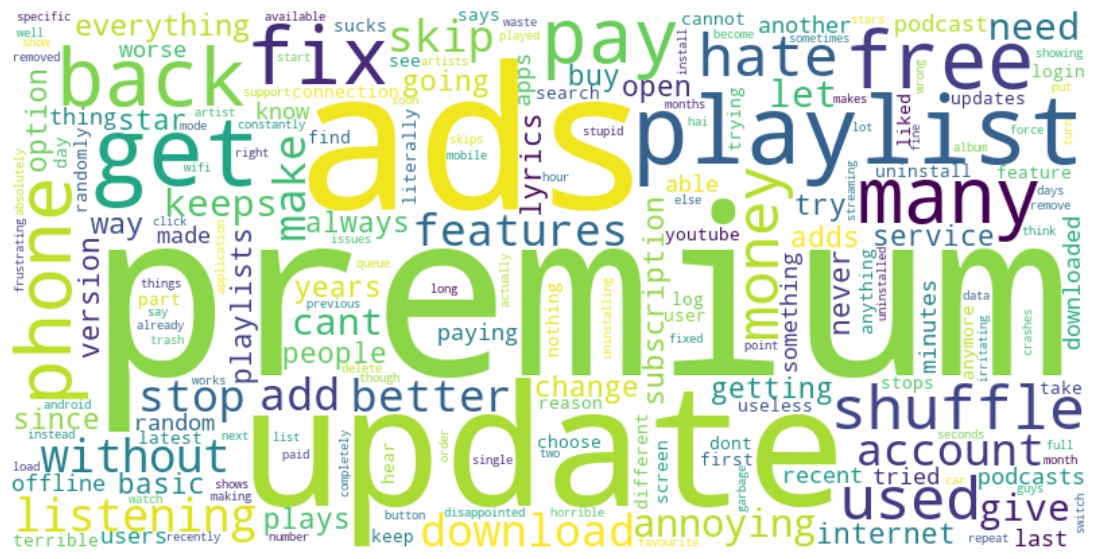

In [32]:
wordcloud_0 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequency_0)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')
plt.show()

In [36]:
words_5 = set(word_frequency_5.keys())
words_0 = set(word_frequency_0.keys())

overlap_words = words_5.intersection(words_0)
len(overlap_words)

combined_freq = {}

for w in overlap_words:
    combined_freq[w] = word_frequency_5[w] + word_frequency_0[w]

top20_overlap = sorted(combined_freq.items(), key=lambda x: x[1], reverse=True)[:20]

top20_overlap


[('premium', 84593),
 ('ads', 56633),
 ('update', 45995),
 ('get', 39073),
 ('playlist', 35894),
 ('free', 29015),
 ('listening', 28104),
 ('many', 24146),
 ('better', 22618),
 ('back', 21326),
 ('phone', 20671),
 ('used', 19802),
 ('easy', 19544),
 ('without', 19414),
 ('download', 19126),
 ('find', 18809),
 ('pay', 18740),
 ('amazing', 18697),
 ('make', 18622),
 ('fix', 18316)]

# Using TF-IDF for unique words in 1 and 5 star reviews

TF-IDF matrix shape: (785688, 25685)
Words especially characteristic of 1★ (negative experience vocab):


,word,uniqueness_1_minus_5,avg_tfidf_1star,avg_tfidf_5star
0,update,0.033702,0.036619,0.002917
1,ads,0.020907,0.033877,0.012970
2,premium,0.020632,0.037624,0.016992
3,hate,0.013276,0.014803,0.001527
4,fix,0.011353,0.013080,0.001727
5,shuffle,0.009814,0.011336,0.001521
6,skip,0.008746,0.009948,0.001203
7,basic,0.008672,0.008864,0.000193
8,money,0.008642,0.010966,0.002324
9,pay,0.008260,0.012491,0.004231



Words especially characteristic of 5★ (positive experience vocab):


,word,uniqueness_5_minus_1,avg_tfidf_1star,avg_tfidf_5star
0,easy,0.023081,0.000752,0.023833
1,amazing,0.020912,0.000989,0.021901
2,nice,0.015741,0.001835,0.017575
3,awesome,0.015332,0.000490,0.015821
4,favorite,0.012543,0.002743,0.015286
5,enjoy,0.010225,0.002088,0.012313
6,listening,0.009907,0.008719,0.018626
7,thank,0.009438,0.001336,0.010774
8,quality,0.008331,0.002264,0.010595
9,excellent,0.007836,0.000219,0.008054


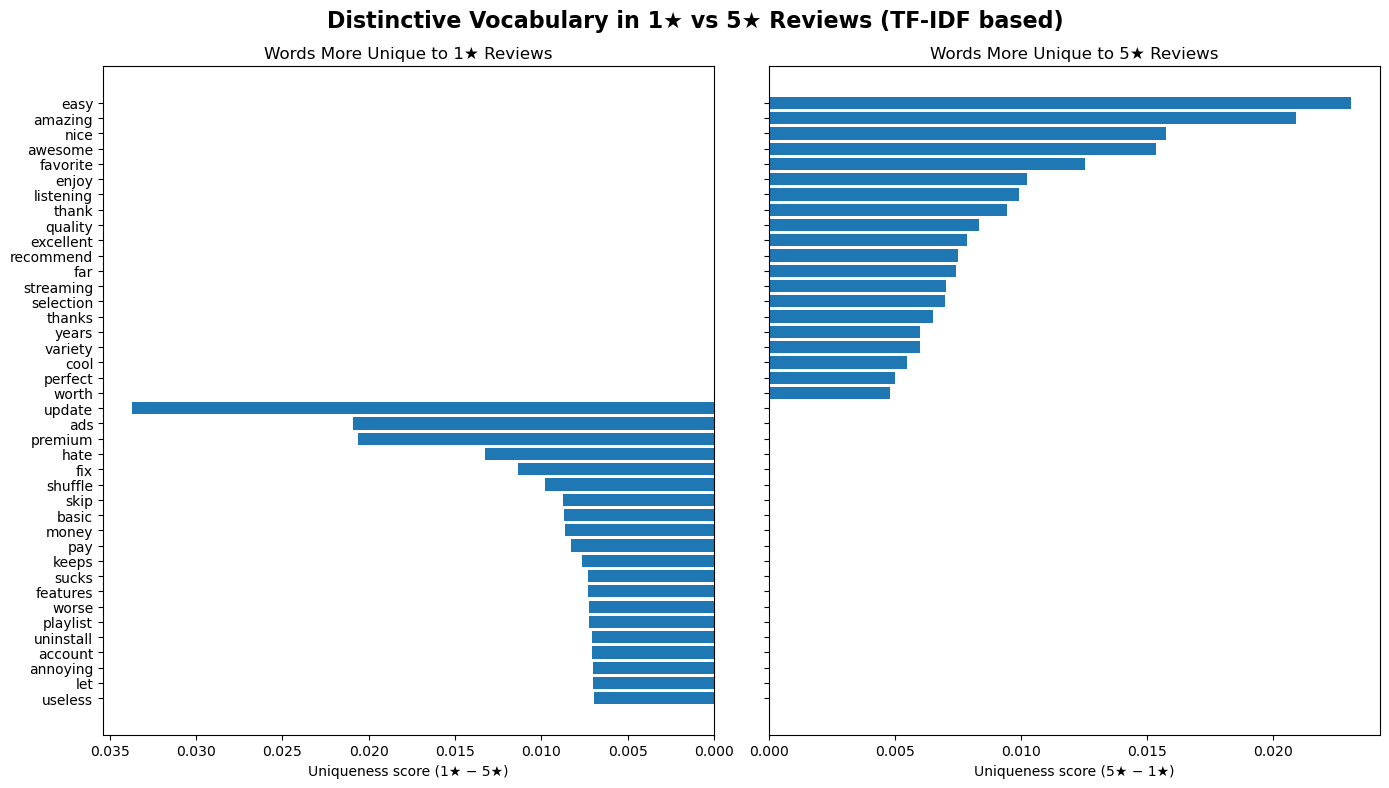

In [31]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


df_final['final_text'] = df_final['final_text'].fillna("")

mask_1 = (df_final['review_rating'] == 1).to_numpy()
mask_5 = (df_final['review_rating'] == 5).to_numpy()

texts = df_final['final_text']


vectorizer = TfidfVectorizer(
    stop_words='english',   
    max_df=0.9,             
    min_df=5                
)

tfidf_all = vectorizer.fit_transform(texts)
feature_names = np.array(vectorizer.get_feature_names_out())

print("TF-IDF matrix shape:", tfidf_all.shape)  


tfidf_1 = tfidf_all[mask_1, :]
tfidf_5 = tfidf_all[mask_5, :]

mean_1 = np.asarray(tfidf_1.mean(axis=0)).ravel()   
mean_5 = np.asarray(tfidf_5.mean(axis=0)).ravel()   


score_1 = mean_1 - mean_5
score_5 = mean_5 - mean_1

TOP_N = 20  

top_idx_1 = np.argsort(score_1)[-TOP_N:][::-1]
top_idx_5 = np.argsort(score_5)[-TOP_N:][::-1]


top_1_unique = pd.DataFrame({
    "word": feature_names[top_idx_1],
    "uniqueness_1_minus_5": score_1[top_idx_1],
    "avg_tfidf_1star": mean_1[top_idx_1],
    "avg_tfidf_5star": mean_5[top_idx_1],
})

top_5_unique = pd.DataFrame({
    "word": feature_names[top_idx_5],
    "uniqueness_5_minus_1": score_5[top_idx_5],
    "avg_tfidf_1star": mean_1[top_idx_5],
    "avg_tfidf_5star": mean_5[top_idx_5],
})

print("Words especially characteristic of 1★ (negative experience vocab):")
display(top_1_unique)

print("\nWords especially characteristic of 5★ (positive experience vocab):")
display(top_5_unique)


top_1_plot = top_1_unique.sort_values("uniqueness_1_minus_5")
top_5_plot = top_5_unique.sort_values("uniqueness_5_minus_1")

fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

axes[0].barh(top_1_plot['word'], top_1_plot['uniqueness_1_minus_5'])
axes[0].set_title("Words More Unique to 1★ Reviews")
axes[0].set_xlabel("Uniqueness score (1★ − 5★)")
axes[0].invert_xaxis()

axes[1].barh(top_5_plot['word'], top_5_plot['uniqueness_5_minus_1'])
axes[1].set_title("Words More Unique to 5★ Reviews")
axes[1].set_xlabel("Uniqueness score (5★ − 1★)")

plt.suptitle(
    "Distinctive Vocabulary in 1★ vs 5★ Reviews (TF-IDF based)",
    fontsize=16,
    fontweight="bold"
)
plt.tight_layout()
plt.show()
